## Curved waves interference

In this notebook we visualise the interference pattern between two waves with curved wave fronts.

The Jupyter Notebook is CurvedWaves.ipynb see

https://github.com/opticsf2f/Opticsf2f_CodeBook

We are using the generic term *curved wave* to denote be a slice through a **spherical** or **cylindrical** wave.

However, we are going to neglect the fall off in amplitude of the wave with distance from the source. 

This could be included by adding a $1/r$ or $1/r^{1/2}$ factor in the definition of E1 and E2 in the third cell.

<div class="interactive-start" onclick="initInteractiveCode()" title="This runs Python in your browser, allowing you local calculations">CLICK HERE TO ACTIVATE CODE CELLS</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.colors as colors
from numpy.fft import fft, ifft, fftshift

import matplotlib.colors as colors
import matplotlib.patches as mpatches

import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams["text.latex.preamble"]  = r"\usepackage{amsmath} \usepackage{amssymb} \usepackage[bitstream-charter]{mathdesign}"
mpl.rcParams["text.usetex"] = True

The next cell defines a region of interest to visualise and a resolution. The spatial unit is $\lambda$ so
here we have chosen a region with size $6\lambda\times6\lambda$.

In [2]:
zmin = 0 # z is the horizontal axis so like x in cartesian system
zmax = 6
ymin = -zmax/2   # vertical axis coould be x or y, call it y to agree with standard axes
ymax = zmax/2
dz = 0.025
dy = 0.025
zoom = 1
Z, Y = np.mgrid[zmin/zoom:zmax/zoom:dz/zoom,ymin/zoom:ymax/zoom:dy/zoom]
z_pts, y_pts = np.shape(Z)

Now we define two functions that output the RGB data for the image.

In the first function we visualise positive and negative field as blue and red, repectively.

In the second we visualise the intensity.

In [3]:
def RGB_data1(D,field):
    R = np.zeros((z_pts,y_pts))
    G = np.zeros((z_pts,y_pts))
    B = np.zeros((z_pts,y_pts))

    E1 = np.exp(2.0j*np.pi*np.sqrt((Y-D)**2+Z**2)) # to model a spherical wave * 1/((Y-D)**2+Z**2)+eps) where e.g. eps = 1e-8 to avoid an infinity
    E2 = np.exp(2.0j*np.pi*np.sqrt((Y+D)**2+Z**2))
    
    E = E1 + E2
    if field == 0:
        R -=  0.4*E.real
        B +=  0.4*E.real
    elif field == 1:
        R -=  0.6*E1.real
        B +=  0.6*E1.real
    else:
        R -=  0.6*E2.real
        B +=  0.6*E2.real
    br=1.0
    bg=1.0 
    bb=1.0 

    R=np.clip(br*R,0.0,1.0)
    G=np.clip(bg*G,0.0,1.0)
    B=np.clip(bb*B,0.0,1.0)
    RGB=np.dstack((np.flipud(R.T), np.flipud(G.T), np.flipud(B.T))) # use transpose to swap image axes, flipud to origin at bottom left
    return RGB

def RGB_data2(D,field):
    R = np.zeros((z_pts,y_pts))
    G = np.zeros((z_pts,y_pts))
    B = np.zeros((z_pts,y_pts))

    E1 = np.exp(2.0j*np.pi*np.sqrt((Y-D)**2+Z**2))
    E2 = np.exp(2.0j*np.pi*np.sqrt((Y+D)**2+Z**2))
    
    E = E1 + E2
    if field == 0:
        R -=  0.4*E.real
        B +=  0.4*E.real
    else:
        G += 0.2*(E.real*E.real + E.imag*E.imag)
    br=1.0
    bg=1.0 
    bb=1.0 

    R=np.clip(br*R,0.0,1.0)
    G=np.clip(bg*G,0.0,1.0)
    B=np.clip(bb*B,0.0,1.0)
    RGB=np.dstack((np.flipud(R.T), np.flipud(G.T), np.flipud(B.T))) # use transpose to swap image axes, flipud to origin at bottom left
    return RGB


Next we want a function to add some arrows and text to the plots.

In [4]:
def plotting_function(ax_ref,label_str,Dys):
    fs = 48
    axs[ax_ref].scatter(Pxs,Pys,color='white',s=[100])
    axs[ax_ref].scatter(0,P0,color='white',s=[100])
    axs[ax_ref].text(z_pts/15,z_pts/7,label_str,fontsize = fs, color='white')
    axs[ax_ref].set_axis_off()
    arrow = mpatches.FancyArrow(0, P0,  Pxs, Pys - P0, width=2, head_width = 8, 
                            head_length = 30, length_includes_head=True, color = 'white')
    axs[ax_ref].add_patch(arrow)
    axs[ax_ref].text(z_pts/4,z_pts/2,r'$\overline{\boldsymbol{r}}$',fontsize = fs, color='white')
    axs[ax_ref].text(5*z_pts/8,9*z_pts/16,r'P',fontsize = fs, color='white')
    NormalArrowLen = 50    
    for DD in Dys:
        axs[ax_ref].scatter(0,P0-DD,color='white',s=[100])
        axs[ax_ref].scatter(-30,P0,color='black',s=[100])
        if DD < 0:
            axs[ax_ref].text(-50,-DD+P0+40,r'$\boldsymbol{d}_2$',fontsize = fs, color='black')
        else:
            axs[ax_ref].text(-50,-DD+P0-20,r'$\boldsymbol{d}_1$',fontsize = fs, color='black')

        arrow = mpatches.FancyArrow(-30, P0,  0, -DD , width=2, head_width = 8, 
                            head_length = 30, length_includes_head=True, color = 'black')
        axs[ax_ref].add_patch(arrow)

        Slope = np.arctan((Pys-(P0-DD))/Pxs)
        arrow = mpatches.FancyArrow(Pxs, Pys,  NormalArrowLen*np.cos(Slope),  NormalArrowLen*np.sin(Slope), width=2, head_width = 8, 
                                    head_length = 30, length_includes_head=True, color = 'white')
        axs[ax_ref].add_patch(arrow)   

Finally, we make a series of images. In this case for field one, field two and both together to illustrate interference.

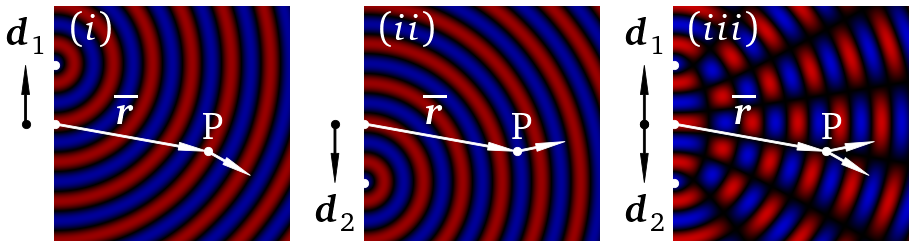

In [5]:
start_time = time.time()

fig, axs = plt.subplots(1,3,figsize=(15, 5),dpi=60)

Px = 3.9
Py = 3.7
Pxs = Px/dz
Pys = Py/dy
P0 = y_pts/2
D = 1.5

Dys = [D/dy]
axs[0].imshow(RGB_data1(D,1))
plotting_function(0,'$(i)$',Dys)

Dys = [-D/dy]
axs[1].imshow(RGB_data1(D,2))
plotting_function(1,'$(ii)$',Dys)

Dys = [-D/dy, D/dy]
axs[2].imshow(RGB_data1(D,0))
plotting_function(2,'$(iii)$',Dys)

plt.subplots_adjust(left=0.0,bottom=0.0,right=1.0,top=1.0,wspace=0.1,hspace=0.1)

In [6]:
fig.savefig('CircWaves1.png')

In [7]:
def plotting_function2(ax_ref1,ax_ref2,label_str,Dys):
    fs = 48
    axs[ax_ref1,ax_ref2].scatter(Pxs,Pys,color='white',s=[100])
    axs[ax_ref1,ax_ref2].scatter(0,P0,color='white',s=[100])
    axs[ax_ref1,ax_ref2].text(z_pts/15,z_pts/8,label_str,fontsize = fs, color='white')
    axs[ax_ref1,ax_ref2].set_axis_off()
    arrow = mpatches.FancyArrow(0, P0,  Pxs, Pys - P0, width=2, head_width = 8, 
                            head_length = 30, length_includes_head=True, color = 'white')
    axs[ax_ref1,ax_ref2].add_patch(arrow)
    axs[ax_ref1,ax_ref2].text(z_pts/4,z_pts/2,r'$\overline{\boldsymbol{r}}$',fontsize = 1.5*fs, color='white')
    axs[ax_ref1,ax_ref2].text(5*z_pts/8,9*z_pts/16,r'P',fontsize = 1.5*fs, color='white')
    NormalArrowLen = 50    
    for DD in Dys:
        axs[ax_ref1,ax_ref2].scatter(0,P0-DD,color='white',s=[100])        
        Slope = np.arctan((Pys-(P0-DD))/Pxs)
        arrow = mpatches.FancyArrow(Pxs, Pys,  NormalArrowLen*np.cos(Slope),  NormalArrowLen*np.sin(Slope), width=2, head_width = 8, 
                                    head_length = 30, length_includes_head=True, color = 'white')
        axs[ax_ref1,ax_ref2].add_patch(arrow)   

Now, we want to look at how the interference patterns look very different for field and intensity.
The left and right columns show the interference patterns for field and intensity, respectively.
As we move down the columns we increase the separation between the sources.

--- 0.1754932403564453 seconds ---


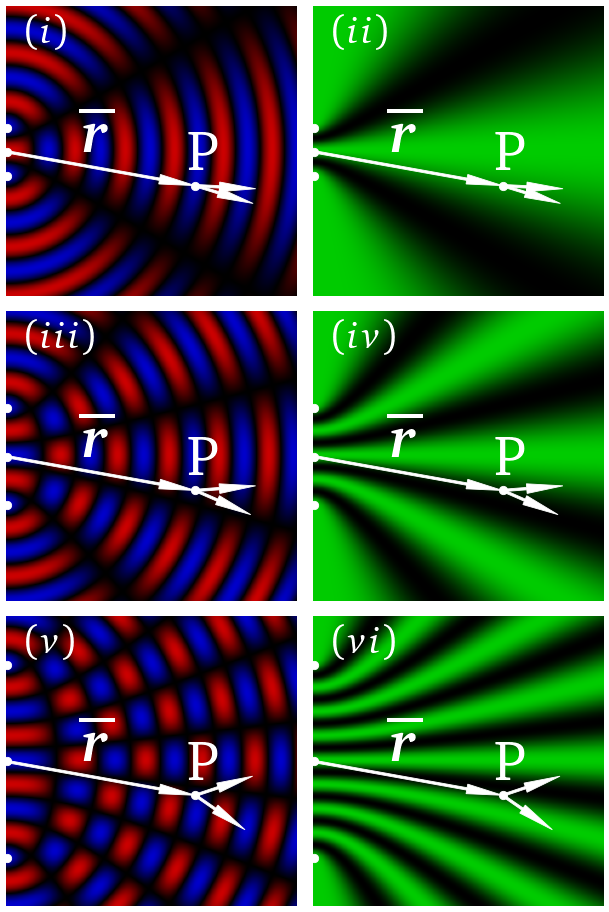

In [8]:
start_time = time.time()

fig, axs = plt.subplots(3,2,figsize=(10, 15),dpi=60)

D = 0.5
Dys = [-D/dy, D/dy]
axs[0,0].imshow(RGB_data2(D,0))
plotting_function2(0,0,'$(i)$',Dys)
axs[0,1].imshow(RGB_data2(D,1))
plotting_function2(0,1,'$(ii)$',Dys)

D = 1.0
Dys = [-D/dy, D/dy]
axs[1,0].imshow(RGB_data2(D,0))
plotting_function2(1,0,'$(iii)$',Dys)
axs[1,1].imshow(RGB_data2(D,1))
plotting_function2(1,1,'$(iv)$',Dys)

D = 2.0
Dys = [-D/dy, D/dy]
axs[2,0].imshow(RGB_data2(D,0))
plotting_function2(2,0,'$(v)$',Dys)
axs[2,1].imshow(RGB_data2(D,1))
plotting_function2(2,1,'$(vi)$',Dys)

plt.subplots_adjust(left=0.0,bottom=0.0,right=1.0,top=1.0,wspace=0.05,hspace=0.05)
print("--- %s seconds ---" % (time.time() - start_time))

In [9]:
fig.savefig('CircWaves2.png')